In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import h5py
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
herwig = "../data/events_anomalydetection_DelphesHerwig_qcd_features.h5"
pythiabg = "../data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5"
pythiasig = "../data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"

datatypes = ["herwig", "pythiabg", "pythiasig"]
df = {}

df["herwig"] = pd.read_hdf(herwig)
df["pythiabg"] = pd.read_hdf(pythiabg)
df["pythiasig"] = pd.read_hdf(pythiasig)

In [3]:
for datatype in datatypes:
    df[datatype]["tau21j1"] = df[datatype]["tau2j1"] / df[datatype]["tau1j1"]
nsubjetherwig = df["herwig"]["tau21j1"]
data = np.asarray(nsubjetherwig)
data2 = data[0:256]
short_data = data[0:256].T
short_data = torch.FloatTensor(short_data)
short_data = short_data.unsqueeze(0)
print(short_data.size())

torch.Size([1, 256])


In [4]:
short_data = short_data.permute(1,0)
print(short_data.size())

torch.Size([256, 1])


In [5]:
Series_Length = 1
g_input_size = 1    
g_hidden_size = 256 
g_output_size = Series_Length
d_input_size = Series_Length
d_hidden_size = 256
d_output_size = 1
d_minibatch_size = 256 
g_minibatch_size = 256

num_epochs = 10000
print_interval = 1000
d_learning_rate = 4e-3
g_learning_rate = 8e-3

In [6]:
def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()
noise_data  = get_noise_sampler()

In [7]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.xfer = torch.nn.SELU()

    def forward(self, x):
        x = self.xfer( self.map1(x) )
        x = self.xfer( self.map2(x) )
        return self.xfer( self.map3( x ) )
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        return torch.sigmoid( self.map3(x) )

In [8]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

In [9]:
criterion = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate ) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate ) #, betas=optim_betas)

In [10]:

def train_D_on_actual() :
    real_data = short_data
    decision = D(real_data)
    error = criterion( decision, torch.ones( d_minibatch_size, 1 ))  # ones = true
    error.backward()

def train_D_on_generated() :
    noise = noise_data( d_minibatch_size, g_input_size )
    fake_data = G( noise ) 
    decision = D( fake_data )
    error = criterion( decision, torch.zeros( d_minibatch_size, 1 ))  # zeros = fake
    error.backward()
    
def train_G():
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = criterion( fake_decision, torch.ones( g_minibatch_size, 1 ) )  # we want to fool, so pretend it's all genuine

    error.backward()
    return error.item(), fake_data

In [11]:
losses = []

for epoch in range(num_epochs):
    D.zero_grad()
    
    train_D_on_actual()    
    train_D_on_generated()
    d_optimizer.step()
    
    G.zero_grad()
    loss,generated = train_G()
    g_optimizer.step()
    
    losses.append( loss )
    if( epoch % print_interval) == (print_interval-1) :
        print( "Epoch %6d. Loss %5.3f" % ( epoch+1, loss ) )
        
print( "Training complete" )

Epoch   1000. Loss 0.703
Epoch   2000. Loss 0.715
Epoch   3000. Loss 0.715
Epoch   4000. Loss 0.688
Epoch   5000. Loss 0.695
Epoch   6000. Loss 0.693
Epoch   7000. Loss 0.692
Epoch   8000. Loss 0.693
Epoch   9000. Loss 0.692
Epoch  10000. Loss 0.691
Training complete


In [12]:
import matplotlib.pyplot as plt

def draw( data ) :    
    plt.figure()
    d = data.tolist() if isinstance(data, torch.Tensor ) else data
    plt.hist( d ) 
    plt.show()

In [13]:
np_arr = generated.cpu().detach().numpy()

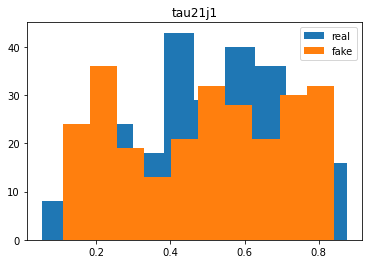

In [15]:
plt.hist(data2,label ='real')
plt.hist(np_arr,label='fake')
plt.title('tau21j1')
plt.legend()